# Prepación de los Datos

En la notebook anterior, hicimos la exploración de los datos y los dividimos en conjunto de entrenamiento y prueba.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)

# Cargamos los datos
df_housing = pd.read_csv("./data/housing.csv")

# Creamos nuestro atributo categórico para los ingresos
df_housing["income_cat"] = pd.cut(df_housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Dividimos los datos en conjunto de entrenamiento y prueba
strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing["income_cat"], random_state=42)

# Eliminamos la categoria income_cat de ambos conjuntos porque no la usamos
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Separamos los predictores de las etiquetas

In [3]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Limpieza de Datos

La mayoría de los algoritmos de aprendizaje automático no pueden trabajar con características faltantes, por lo que debemos ocuparnos de esto. Por ejemplo, vimos que el atributo `total_bedrooms` tiene algunos valores faltantes. Existen tres opciones para solucionar esto:

1. Eliminar los distritos correspondientes.
2. Eliminar el atributo.
3. Reemplazar los valores faltantes con algún valor (cero, la media, la mediana, etc.). A esto se llama _imputación_.

In [4]:
# índices de las filas con datos faltantes
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [5]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # opción 1: elimino los distritos con datos faltantes

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [6]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # opción 2: elimino la columna

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [7]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # opción 3: reemplazo los valores faltantes con la mediana

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


vamos a optar por la opción 3 ya que es la menos destructiva, pero en lugar del código anterior, usaremos una clase de Scikit-Learn:   `SimpleImputer`. 

La ventaja que esto posee es que almacenará el valor de la mediana de cada característica. Esto permitirá imputar valores faltantes no solo en el conjunto de entrenamiento, sino también en el conjunto de pruebas y cualquier dato nuevo que ingrese al modelo.

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

La mediana solo puede calcularse en atributos numéricos, creamos una copia de los datos solo con atributos numéricos (excluyendo `ocean_proximity`)

In [9]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [10]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [11]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])


Ahora se puede usar este imputador "entrenado" para transformar el conjunto de entrenamiento reemplazando los valores faltantes con las medianas calculadas:

In [14]:
X = imputer.transform(housing_num) # me devuelve un numpy array
type(X)

numpy.ndarray

Los valores faltantes también pueden reemplazarse con el valor medio `(strategy="mean")`, o con el valor más frecuente `(strategy="most_frequent")`, o con un valor constante `(strategy="constant", fill_value=...)`. Las dos últimas estrategias admiten datos no numéricos.

In [15]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [16]:
housing_train = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


## Manejo de atributos categóricos

Nuestro conjunto de datos tiene el atributo `ocean_proximity` que es de tipo categórico. La mayoría de algoritmos de aprendizaje maquinal no trabaja con atributos numéricos, por lo que debemos convertir estas categorías de tipo texto a un valor numérico.

In [17]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


Primero probaremos la clase `OrdinalEncoder` de Scikit-Learn

In [18]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [19]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [20]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Un problema con esta representación es que los algoritmos de aprendizaje maquinal asumirán que dos valores cercanos son más similares que dos valores distantes. Esto puede ser aceptable en algunos casos (por ejemplo, para categorías ordenadas como "malo", "regular", "bueno" y "excelente"), pero no es el caso para la columna ocean_proximity (por ejemplo, las categorías 0 y 4 son claramente más similares que las categorías 0 y 1). 

Para solucionar este problema, una solución común es crear un atributo binario por categoría: un atributo igual a 1 cuando la categoría es `<1H OCEAN` (y 0 en caso contrario), otro atributo igual a 1 cuando la categoría es `INLAND` (y 0 en caso contrario), y así sucesivamente. Esto se llama codificación _one-hot_, porque solo un atributo será igual a 1 (activo), mientras que los demás serán 0 (inactivo). Los nuevos atributos a veces se llaman atributos ficticios (atributos _dummy_). Scikit-Learn proporciona la clase OneHotEncoder para convertir valores categóricos en vectores one-hot.

Clase `OneHotEncoder` de Scikit-Learn

In [21]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Por defecto, la salida de un `OneHotEncoder` es una matriz rala (sparse matrix), en lugar de un arreglo NumPy. Una matriz rala es una representación muy eficiente para matrices que contienen principalmente ceros. Internamente, solo almacena los valores no nulos y sus posiciones. Cuando un atributo categórico tiene cientos o miles de categorías, codificarlo con one-hot resulta en una matriz muy grande llena de 0s excepto por un solo 1 por fila. Una matriz rala ahorra mucha memoria y acelerará los cálculos. 

Se puede usar una matriz rala de manera similar a un arreglo 2D normal, pero se puede convertir a un arreglo NumPy (denso) con el método `toarray()`. También puede fijarse `sparse=False` al crear el `OneHotEncoder`, en cuyo caso el método `transform()` devolverá directamente un arreglo NumPy.

In [22]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Cuando entrenamos cualquier estimador de Scikit-Learn utilizando un DataFrame, el estimador guarda los nombres de las columnas en el atributo `feature_names_in_`. Luego, Scikit-Learn asegura que cualquier DataFrame proporcionado a este estimador después de de ser entrenado (por ejemplo, a transform() o predict()) tenga los mismos nombres de columnas. También proporcionan un método `get_feature_names_out()` que se puede usar para construir un DataFrame:

In [23]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [24]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [25]:
df_housing_cat_1hot = pd.DataFrame(housing_cat_1hot.toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=housing_cat.index)

df_housing_cat_1hot

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


## Transformación y escalado de características

Una de las transformaciones más importantes es el _escalado de características_ (feature scaling). Con pocas excepciones, los algoritmos de aprendizaje maquinal no resultan en un buen desempeño cuando las atributos numéricos de entrada tienen escalas muy diferentes. En nuestro caso: el número total de habitaciones varía entre 6 a 39,320, los ingresos solo varían desde 0 hasta 15. Sin escalar previamente los datos, la mayoría de los modelos estarían sesgados a ignorar el `median_income` y enfocarse en 'total_rooms'.

Existen dos formas: el escalado _min-max_ y la _estandarización_.

### Escalado min-max

Se lo llama comunmente normalización. Para cada atributo, los valores se escalan en el rango entre 0 a 1. Esto se logra restando el valor mínimo y dividiendo por la diferencia entre el mínimo y el máximo. 
Scikit-Learn tiene un _transformer_ llamado `MinMaxScaler` para esto. Tiene un hiperparámetro `feature_range` para cambiar el rango si no se quiere de 0 a 1 (por ejemplo, las redes neuronales funcionan mejor con entradas de media cero, por lo que un rango de -1 a 1 es preferible).

In [26]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [27]:
housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

### Estandarización

Primero se resta el valor medio (los valores estandarizados tienen media de cero), luego divide el resultado por el desvío estándar (los valores tienen un desvío estándar igual a 1). A diferencia del escalado min-max, la estandarización no restringe los valores a un rango específico. La estandarización se ve mucho menos afectada por los valores atípicos. 

Scikit-Learn proporciona un _transformer_ llamado `StandardScaler`:

In [28]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [29]:
housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

✅ Si se quiere escalar una matriz rala sin convertirla en una matriz densa, se puede utilizar `StandardScaler` con el hiperparámetro `with_mean` igual a `False`. Esto solo dividirá los datos por el desvío estándar, sin restar la media (sino dejaría de ser rala):

Cuando la distribución de una característica está muy sesgada, tanto el escalado min-max como la estandarización comprimirán la mayoría de los valores en un rango pequeño. Por lo tanto, antes de escalar un atributo, se debería transformar para reducir el sesgo y, si es posible, hacer que la distribución sea aproximadamente simétrica (normal). 

Una forma común de hacer esto para características positivas con sesgo hacia la derecha es reemplazar la característica por su raíz cuadrada (o elevar la característica a una potencia entre 0 y 1). 

Si la característica tiene una cola muy larga y pesada (sesgo), como una distribución de potencias, se puede reemplazar la característica por su logaritmo. 

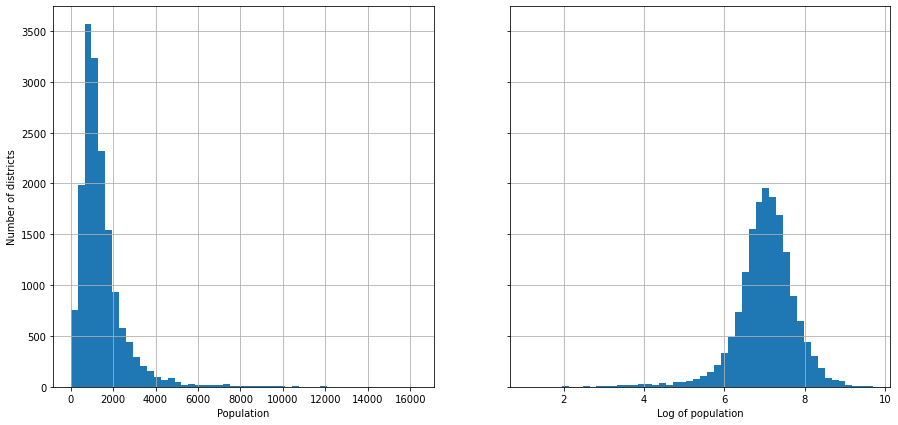

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

Otro enfoque consiste en dividir la característica en "buckets" o intervalos. Esto implica dividir su distribución en intervalos de tamaño aproximadamente igual y reemplazar cada valor de la característica con el índice del intervalo al que pertenece. Por ejemplo, podríamos reemplazar cada valor con su percentil. Esto resulta en una característica con una distribución casi uniforme, por lo que no es necesario realizar escalado, o simplemente se puede dividir por el número de intervalos para forzar que los valores estén en el rango de 0 a 1.

In [31]:
percentiles = [ np.percentile(housing["median_income"], p) for p in range(1, 100) ]

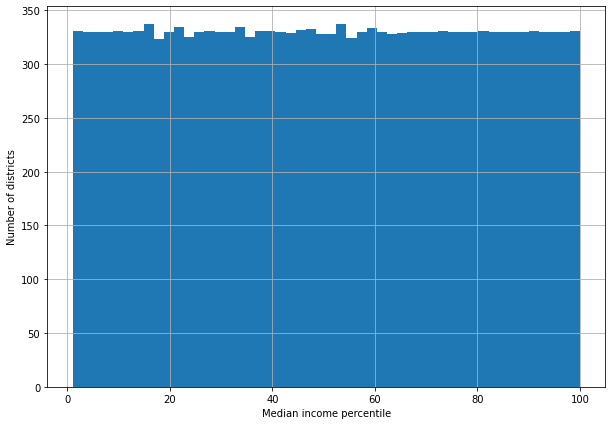

In [32]:
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))

flattened_median_income.hist(bins=50, figsize=(10,7))
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

Hasta ahora, solo hemos analizado las características de entrada, pero es posible que también sea necesario transformar los valores target. Por ejemplo, si la distribución del target tiene un sesgo, podemos aplicarle el logaritmo. Sin embargo, un modelo de regresión predecirá el logaritmo del `median_income`, no el valor en sí. Deberíamos calcular la exponencial de la predicción para obtener el valor buscado.

## Resumen de la segunda parte: Preparación de los datos

En esta segunda parte:
- Hicimos una limpieza de los datos de entrenamiento:
    - Manejo de datos faltantes o erróneos. Imputamos valores (media, mediana, etc)
- Manejo de atributos categóricos
    - OrdinalEncoder
    - Codificación OneHot
- Transformación y escalado de atributos